In [3]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable
import pylab as plt

def est_psd(lst,d):
    S = len(lst)
    for s in range(S):
        x = lst[s]
        hatx = torch.rfft(x ,1 ,onesided=False)
        amp2 = hatx[:,0]*hatx[:,0]+hatx[:,1]*hatx[:,1]
        if s==0:
            psd = amp2/d
        else:
            psd = psd + amp2/d
    psd = psd/S
    return psd

def gauss_omega_mcmc_simulate_omega(Y_0 ,langevin_step_size ,langevin_step_num ,signal_size, beta, samplestep = 100):
    assert(signal_size %2 ==0)
    d = signal_size
    Y_tau = Y_0.clone().requires_grad_(True)
    Lambda = np.zeros(d)
    invLambda = np.zeros(d)
    for k in range(d):
        if k < d/2:
            omega = 2*math.pi * k / d
        else:
            omega = 2*math.pi * k / d - 2*math.pi
        if k==0:
            Lambda[k] = 0
            invLambda[k] = 0
        else:
            Lambda[k] = (abs(omega) ** (-beta))
            invLambda[k] = 1/Lambda[k]
    #plt.plot(Lambda)
    lst_noise = []
    lst_ytau = []
    for i in range(langevin_step_num):
        if Y_tau.grad is not None:
            Y_tau.grad.data.zero_()
        noise = torch.randn(d)
        if i % samplestep == 0:
            lst_noise.append(noise)
            lst_ytau.append(Y_tau)
        Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
        Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
        #plt.plot(Y_aftau.numpy()/d)
        beta_omega = torch.Tensor(invLambda)
        Y_mul = (Y_aftau*beta_omega)/d
        #plt.plot(Y_mul.numpy())
        log_pY = -0.5 * Y_mul.sum() # -logZ
        log_pY.backward()
        Y_diff = 0.5 * (langevin_step_size**2)*Y_tau.grad + langevin_step_size * noise
        #print(i, Y_tau.grad.norm()) # Y_tau, noise, Y_tau.grad)
        Y_tau.data.add_(Y_diff.data)
        #rint(i,log_pY)
    
    return lst_noise, lst_ytau, Lambda


In [5]:
langevin_step_size = 0.005
langevin_step_num = 200000
beta = 0.8 # 1.2 # decay of power spectrum, Lambda(om) = |om|^(-beta)
image_size = 64

Y_0 =  torch.randn(image_size)
lst_noise, lst_ytau, Lambda = gauss_omega_mcmc_simulate_omega(Y_0 ,langevin_step_size ,langevin_step_num ,image_size, beta)
psd_noise = est_psd(lst_noise,image_size)
psd_ytau = est_psd(lst_ytau,image_size)


(array([4.48159873e-04, 8.23765702e-04, 6.31380593e-04, 3.84741608e-04,
        1.63415854e-04, 2.99511212e-05, 7.29857038e-06, 7.37446535e-05,
        1.76491652e-04, 2.56897009e-04, 2.75722239e-04, 2.27503784e-04,
        1.38727788e-04, 5.20851645e-05, 5.12563247e-06, 1.34570992e-05,
        6.56972989e-05, 1.31369219e-04, 1.76857036e-04, 1.81239957e-04,
        1.44627193e-04, 8.58199055e-05, 3.14598983e-05, 2.66025131e-06,
        5.74354499e-06, 3.11053009e-05, 5.99107843e-05, 7.45545258e-05,
        6.73603863e-05, 4.33848800e-05, 1.64887242e-05, 1.26888688e-06,
        5.29138197e-06, 2.55454506e-05, 5.06029246e-05, 6.69794099e-05,
        6.61894737e-05, 4.88876431e-05, 2.41955004e-05, 4.84090560e-06,
        7.64725542e-07, 1.44155283e-05, 3.98962075e-05, 6.60976657e-05,
        8.20313071e-05, 8.16802785e-05, 6.61667073e-05, 4.25135913e-05,
        1.99473325e-05, 5.71925284e-06, 2.39740052e-06, 7.63566004e-06,
        1.61355201e-05, 2.25440508e-05, 2.38030043e-05, 1.997877

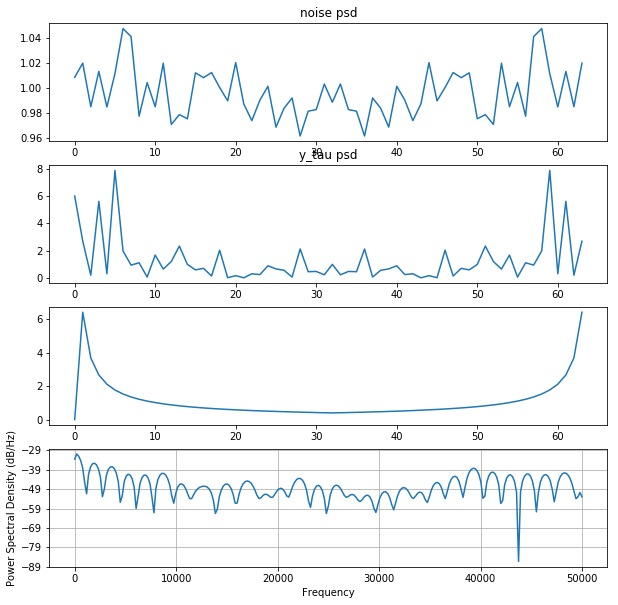

In [20]:
import matplotlib.mlab as mlab
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(psd_noise.data.numpy())
plt.title('noise psd')
plt.subplot(412)
plt.plot(psd_ytau.data.numpy())
plt.title('y_tau psd')
plt.subplot(413)
plt.plot(Lambda)
plt.subplot(414)
plt.psd(psd_ytau.data.numpy(), NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)